In [21]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nibabel
import nibabel.processing
import os

from scipy import ndimage

from matplotlib import pyplot
import os
from skimage.filters import threshold_otsu
import cc3d
from tensorflow.keras import Input, Model
from scipy.ndimage import zoom
from matplotlib import animation, rc
from IPython import display 

In [4]:
#USE SMALL GPU#
use_gpu = 1
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load an image, preprocess, show it.

In [3]:
#Borrowed from the 3D preprocessing

def normalize(volume):
    """Normalize the volume"""
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def pp(original_image):
    
    input_img=input_img = nibabel.load("{0}".format(original_image))
    resampled_img = nibabel.processing.conform(input_img, out_shape=(100,100,90), voxel_size=(2.0, 2.0, 2.0))
    
    img = resampled_img.get_fdata()
    
    thresh = threshold_otsu(img)
    bw_img1 = np.copy(img)
    bw_img1[bw_img1 < thresh] = 0
    bw_img1[bw_img1 >= thresh] = 255
    
    input_CCA=bw_img1.astype('int32')
    connectivity = 6
    labels_out, N = cc3d.connected_components(input_CCA, return_N=True)
    
    def mask_largest_label (labels_out, N):
        #print("This function returns the largest blob of a CCA processed image as a binary mask")
        #print("")
        def separate_labels(label_ID, label_matrix):
            mask=1*(label_matrix == label_ID)
            return mask
        labellist=[]
        for j in range(1, N+1):
            a=separate_labels(j, labels_out)
            labellist.append(a)
        #print("The image has {0} labels".format(len(labellist)))
        z=labellist[0]
        #print("The shape of the labels is: {0}".format(z.shape))
        sizelist=[]
        for counter,element in enumerate (labellist):
            a=labellist[counter].sum()
            sizelist.append(a)
        #print("Label sizes: {0}".format(sizelist))
        sizelist=np.asarray(sizelist)
        a=sizelist.argmax()
        #print("The largest label index is: {0}".format(a))
        mask=labellist[a]
        #print("The largest label is now a binary mask with shape {0}, size {1}, max value {2} and min value {3}".format((mask.shape),(mask.sum()),(mask.max()),(mask.min())))
        return mask

    mask=mask_largest_label(labels_out, N)
    
    pimg=np.multiply(img,mask)
    
    return pimg

def process(path):
    """Read and normalize volume"""
    # Read and pp scan
    volume = pp(path)
    # Normalize
    volume = normalize(volume)
    #Prepare for NN input
    volume = np.expand_dims(volume, axis=0)
    volume = np.expand_dims(volume, axis=4)
    return volume

In [63]:
example="/local_mount/space/celer/1/users/notebooks/moises/pdata/newdata/kfold2/fold3/pMCI/016_S_1117_I183352.nii"

In [64]:
volume=process(example)

Dimensions of the CT scan are: (100, 100, 90)


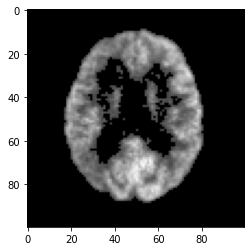

In [65]:
image = np.squeeze(volume)

print('Dimensions of the CT scan are:', image.shape)
imagey=np.rot90(image)
plot=plt.imshow(imagey[:, :, 46], cmap='gray')

In [66]:
def plot_slices(data, num_rows=4, num_columns=10, width=100, height=100):
    data=data[:, :, 25:65]
    """Plot a montage of CT slices"""
    data = np.rot90(np.array(data))
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    _, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


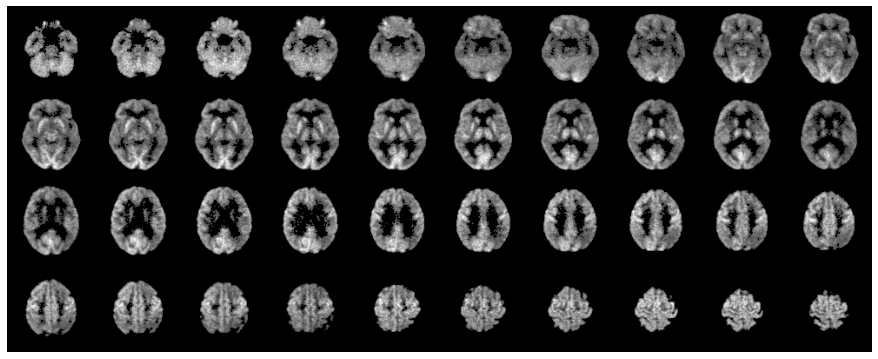

In [67]:
plot_slices(image)

# Load model, make simple prediction

In [68]:
modeldir="/local_mount/space/celer/1/users/notebooks/moises/saved_models/newconv_originalsmallcnn2/epoch17"

In [69]:
model=tf.keras.models.load_model(modeldir)

In [ ]:
model.summary()

In [70]:
prediction = model.predict(volume)

In [71]:
score=prediction[0][0]
score

0.6196538

# Heatmap

In [31]:
volume_size = (100, 100, 90, 1)
last_conv_layer_name = 'conv3d_4'

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [72]:
# Remove last layer's activation
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(volume, model, last_conv_layer_name)

In [24]:
heatmap.shape

(6, 6, 5)

In [25]:
np.squeeze(heatmap).shape

(6, 6, 5)

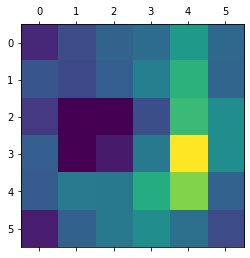

In [27]:
plt.matshow(np.squeeze(heatmap[:, :, 4]))
plt.show()

In [73]:
def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap


resized_heatmap = get_resized_heatmap(heatmap, volume_size)

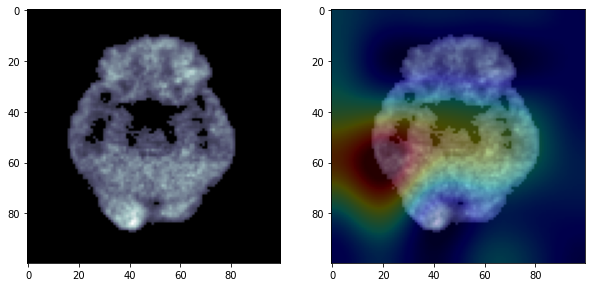

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
35
ax[0].imshow(np.rot90(np.squeeze(image[:, :, 30])), cmap='bone')
img0 = ax[1].imshow(np.rot90(np.squeeze(image[:, :, 30])), cmap='bone')
img1 = ax[1].imshow(np.rot90(np.squeeze(resized_heatmap[:, :, 30])),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

# Nibabel

In [75]:
input_img= nibabel.load("{0}".format(example))

In [76]:
aff=input_img.affine

In [77]:
vol=np.squeeze(volume)
vol.shape

(100, 100, 90)

In [78]:
resized_heatmap.shape

(100, 100, 90)

In [79]:
saved_img = nibabel.Nifti1Image(vol, aff)

In [80]:
nibabel.save(saved_img, '/local_mount/space/celer/1/users/notebooks/moises/heatmaps/example2.nii')

In [81]:
heaty=normalize(resized_heatmap)

In [82]:
saved_heatmap = nibabel.Nifti1Image(heaty, aff)

In [83]:
nibabel.save(saved_heatmap, '/local_mount/space/celer/1/users/notebooks/moises/heatmaps/heatmap2.nii')

In [18]:
rc('animation', html='jshtml')


def create_animation(array, score, heatmap=None, alpha=0.3):
    """Create an animation of a volume"""
    array = np.transpose(array, (2, 0, 1))
    if heatmap is not None:
        heatmap = np.transpose(heatmap, (2, 0, 1))
    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        if heatmap is not None:
            image_plot2 = plt.imshow(
                heatmap[idx], animated=True, cmap='jet', alpha=alpha, extent=image_plot.get_extent())
            aux.append(image_plot2)
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Patient Score: {score}', fontsize=16)
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani

In [19]:
anim=create_animation(image,score, heatmap=resized_heatmap)

In [20]:
anim

In [ ]:
#To save as mp4
writervideo = animation.FFMpegWriter(fps=60) 
anim.save('heatmaptest.mp4', writer=writervideo) 